### 1 随机初始化的alexnet网络训练 

In [8]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms,models
import os
import shutil
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2

In [9]:
#根据paper自己定义的elexnet网络，共8层，5加3，不含dropout层
class myNet(nn.Module):
    
    def __init__(self,num_classes=2):
        super(myNet,self).__init__()
        self.features=nn.Sequential(nn.Conv2d(3,96,11,4,padding=5),
                                   nn.BatchNorm2d(96),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2),
                                   nn.Conv2d(96,256,5,padding=2),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2),
                                   nn.Conv2d(256,384,3,padding=1),
                                   nn.BatchNorm2d(384),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(384,384,3,padding=1),
                                   nn.BatchNorm2d(384),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(384,256,3,padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2),
                                   )
#         self.classifier=nn.Sequential(#nn.Dropout(p=0.5),
#                                      nn.Linear(256*6*6,4096),
#                                      nn.ReLU(inplace=True),
#                                      #nn.Dropout(p=0.5),
#                                      nn.Linear(4096,4096),
#                                      nn.ReLU(inplace=True),
#                                      nn.Linear(4096,num_classes),
#                                      )
        self.classifier=nn.Sequential(#nn.Dropout(p=0.5),
                                     nn.Linear(256*6*6,4096),
                                     nn.ReLU(inplace=True),
                                     #nn.Dropout(p=0.5),
                                     nn.Linear(4096,4096),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(4096,num_classes),
                                     )
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),256*6*6)
        x=self.classifier(x)
        return x

In [10]:
data_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.488,0.455,0.417],std=[0.230,0.225,0.225])#RGB
    #transforms.Normalize(mean=[0.415,0.454,0.487],std=[0.225,0.225,0.230])#
])
#训练数据读取接口
train_dataset=datasets.ImageFolder(root='./copy/train/',
                                  transform= data_transform)
#把数据打包成batch_size大小的tensor
train_loader=torch.utils.data.DataLoader( train_dataset,
                                        batch_size=64,
                                        shuffle=True)
#验证集数据读取接口
val_dataset=datasets.ImageFolder(root='./copy/val/',
                                 transform=data_transform)
val_loader=torch.utils.data.DataLoader(val_dataset,
                                       batch_size=64,
                                       shuffle=True)

In [11]:
print(val_dataset.class_to_idx)

{'cats': 0, 'dogs': 1}


In [12]:
model=myNet()
model=model.cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [21]:
def train():
    
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        train_correct=0
        train_total=0
        
        for i,data in enumerate(train_loader,0):#一个epoch完成后结束for循环
            inputs,train_labels=data
            inputs,labels=Variable(inputs.cuda()),Variable(train_labels.cuda())
            outputs=model(inputs)
            
            #根据网络输出计算此时的准确率
            _,train_predicted=torch.max(outputs.data,1)
            train_correct+=(train_predicted==labels.data).sum()
            
            loss=criterion(outputs,labels)
            
            #计算损失函数中的L2正则化项
#             L2_reg=0
#             for param in model.parameters():
#                 L2_reg+=torch.norm(param)
            
#             loss+=0.1*L2_reg
            
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            train_total+=train_labels.size(0)#记录总共训练了多少幅图像
            
            if (i+1)%10==0: #每隔10个batch就记录一次这10个batch的平均损失值
                print('[%d %5d] loss: %.3f' %(epoch+1,i+1,running_loss/10))
                loss_batch.append(running_loss/10)
                running_loss=0
               
        #print(train_correct.type)
        #print('train acc is %.3f'%(100*train_correct.item()/train_total.item()))
        print('train %d epoch  acc: %4.2f'%(epoch+1, 100*float(train_correct)/float(train_total)))
        
        
        
        #在训练完一个epoch后，用验证集进行验证
        correct=0
        val_loss=0.0
        val_total=0
        model.eval()
        
        for i,data in enumerate(val_loader):
            images,labels=data
            images,labels=Variable(images.cuda()),Variable(labels.cuda())
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            val_total+=labels.size(0)
            correct+=(predicted==labels.data).sum()
            
        print('correct : '+ str(correct)+'  '+'val_total : '+str(val_total) )
        print('val %d epoch loss: %.3f  acc:%4.2f ' %(epoch+1,
                                                     val_loss/(i+1),
                                                     100*float(correct)/float(val_total)))
        if epoch % save_every==0:
            torch.save(model.state_dict(),'./models/model-%d.pkl' % epoch)



In [22]:
loss_batch=[]# 记录训练过程中的损失值
save_every=1 #每一个epoch保存一下网络参数值
epochs=5 

# 开始训练，并记录训练消耗的时间
time_open=time.time()
train()
time_end=time.time()
time_used=time_end-time_open
print('time used : {} minutes'.format(time_used/60))

[1    10] loss: 0.191
[1    20] loss: 0.233
[1    30] loss: 0.229
[1    40] loss: 0.211
[1    50] loss: 0.229
[1    60] loss: 0.227
[1    70] loss: 0.189
[1    80] loss: 0.231
[1    90] loss: 0.253
[1   100] loss: 0.247
[1   110] loss: 0.233
[1   120] loss: 0.197
[1   130] loss: 0.188
[1   140] loss: 0.186
[1   150] loss: 0.196
[1   160] loss: 0.220
[1   170] loss: 0.192
[1   180] loss: 0.206
[1   190] loss: 0.181
[1   200] loss: 0.259
[1   210] loss: 0.226
[1   220] loss: 0.186
[1   230] loss: 0.168
[1   240] loss: 0.190
[1   250] loss: 0.234
[1   260] loss: 0.208
[1   270] loss: 0.234
[1   280] loss: 0.191
[1   290] loss: 0.217
[1   300] loss: 0.225
[1   310] loss: 0.236
[1   320] loss: 0.190
[1   330] loss: 0.230
[1   340] loss: 0.238
[1   350] loss: 0.219
train 1 epoch  acc: 91.00
correct : tensor(2229, device='cuda:0')  val_total : 2500
val 1 epoch loss: 0.253  acc:89.16 
[2    10] loss: 0.157
[2    20] loss: 0.137
[2    30] loss: 0.168


KeyboardInterrupt: 

In [ ]:
# 画出训练集的损失函数曲线图
x=range(1,len(loss_batch)+1)
plt.plot(x,loss_batch)

### 2 用Alexnet网络迁移学习




In [24]:
model=models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.classifier=nn.Sequential(nn.Dropout(p=0.5),
                               nn.Linear(256*6*6,4096),
                               nn.ReLU(inplace=True),
                               nn.Dropout(p=0.5),
                               nn.Linear(4096,4096),
                               nn.ReLU(inplace=True),
                               nn.Linear(4096,2),
                              )
model=model.cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=1e-4)

In [25]:
loss_batch=[]# 记录训练过程中的损失值
save_every=1 #每一个epoch保存一下网络参数值
epochs=5 

# 开始训练，并记录训练消耗的时间
time_open=time.time()
train()
time_end=time.time()
time_used=time_end-time_open
print('time used : {} minutes'.format(time_used/60))

[1    10] loss: 0.362
[1    20] loss: 0.206
[1    30] loss: 0.213
[1    40] loss: 0.245
[1    50] loss: 0.235
[1    60] loss: 0.174
[1    70] loss: 0.223
[1    80] loss: 0.147
[1    90] loss: 0.166
[1   100] loss: 0.171
[1   110] loss: 0.185
[1   120] loss: 0.154
[1   130] loss: 0.152
[1   140] loss: 0.139
[1   150] loss: 0.174
[1   160] loss: 0.132
[1   170] loss: 0.152
[1   180] loss: 0.140
[1   190] loss: 0.160
[1   200] loss: 0.128
[1   210] loss: 0.164
[1   220] loss: 0.148
[1   230] loss: 0.135
[1   240] loss: 0.166
[1   250] loss: 0.098
[1   260] loss: 0.125
[1   270] loss: 0.119
[1   280] loss: 0.110
[1   290] loss: 0.107
[1   300] loss: 0.102
[1   310] loss: 0.080
[1   320] loss: 0.123
[1   330] loss: 0.119
[1   340] loss: 0.122
[1   350] loss: 0.152
train 1 epoch  acc: 93.85
correct : tensor(2384, device='cuda:0')  val_total : 2500
val 1 epoch loss: 0.123  acc:95.36 
[2    10] loss: 0.080
[2    20] loss: 0.087
[2    30] loss: 0.095
[2    40] loss: 0.107
[2    50] loss: 0.105


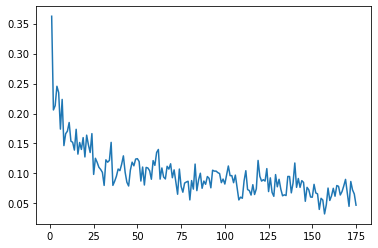

In [27]:
# 画出训练集的损失函数曲线图
x=range(1,len(loss_batch)+1)
plt.plot(x,loss_batch)

### 3 用VGG网络迁移学习

In [ ]:
model=models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.classifier=nn.Sequential(nn.Linear(25088,2048),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(2048,2048),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(2048,2))
model=model.cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=1e-4)

In [ ]:
loss_batch=[]# 记录训练过程中的损失值
save_every=1 #每一个epoch保存一下网络参数值
epochs=5 

# 开始训练，并记录训练消耗的时间
time_open=time.time()
train()
time_end=time.time()
time_used=time_end-time_open
print('time used : {} minutes'.format(time_used/60))

In [ ]:
# 画出训练集的损失函数曲线图
x=range(1,len(loss_batch)+1)
plt.plot(x,loss_batch)

### 4 用ResNet-18网络迁移学习

In [29]:
model=models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
dim_in = model.fc.in_features
model.fc = nn.Linear(dim_in,2)
model=model.cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.fc.parameters(),lr=1e-4)

In [30]:
loss_batch=[]# 记录训练过程中的损失值
save_every=1 #每一个epoch保存一下网络参数值
epochs=5 

# 开始训练，并记录训练消耗的时间
time_open=time.time()
train()
time_end=time.time()
time_used=time_end-time_open
print('time used : {} minutes'.format(time_used/60))

[1    10] loss: 0.698
[1    20] loss: 0.640
[1    30] loss: 0.560
[1    40] loss: 0.537
[1    50] loss: 0.505
[1    60] loss: 0.478
[1    70] loss: 0.446
[1    80] loss: 0.402
[1    90] loss: 0.394
[1   100] loss: 0.368
[1   110] loss: 0.358
[1   120] loss: 0.333
[1   130] loss: 0.301
[1   140] loss: 0.295
[1   150] loss: 0.303
[1   160] loss: 0.297
[1   170] loss: 0.273
[1   180] loss: 0.254
[1   190] loss: 0.246
[1   200] loss: 0.235
[1   210] loss: 0.254
[1   220] loss: 0.229
[1   230] loss: 0.250
[1   240] loss: 0.220
[1   250] loss: 0.216
[1   260] loss: 0.211
[1   270] loss: 0.199
[1   280] loss: 0.206
[1   290] loss: 0.202
[1   300] loss: 0.212
[1   310] loss: 0.198
[1   320] loss: 0.178
[1   330] loss: 0.174
[1   340] loss: 0.182
[1   350] loss: 0.172
train 1 epoch  acc: 90.28
correct : tensor(2409, device='cuda:0')  val_total : 2500
val 1 epoch loss: 0.163  acc:96.36 
[2    10] loss: 0.165
[2    20] loss: 0.170
[2    30] loss: 0.177
[2    40] loss: 0.140
[2    50] loss: 0.181


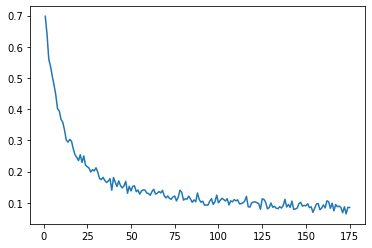

In [31]:
# 画出训练集的损失函数曲线图
x=range(1,len(loss_batch)+1)
plt.plot(x,loss_batch)

### 5 用ResNet-50网络迁移学习

In [32]:
model=models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
dim_in = model.fc.in_features
model.fc = nn.Linear(dim_in,2)
model=model.cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.fc.parameters(),lr=1e-4)

In [33]:
loss_batch=[]# 记录训练过程中的损失值
save_every=1 #每一个epoch保存一下网络参数值
epochs=5 

# 开始训练，并记录训练消耗的时间
time_open=time.time()
train()
time_end=time.time()
time_used=time_end-time_open
print('time used : {} minutes'.format(time_used/60))

[1    10] loss: 0.655
[1    20] loss: 0.568
[1    30] loss: 0.497
[1    40] loss: 0.446
[1    50] loss: 0.407
[1    60] loss: 0.361
[1    70] loss: 0.316
[1    80] loss: 0.301
[1    90] loss: 0.277
[1   100] loss: 0.261
[1   110] loss: 0.243
[1   120] loss: 0.231
[1   130] loss: 0.225
[1   140] loss: 0.212
[1   150] loss: 0.203
[1   160] loss: 0.182
[1   170] loss: 0.188
[1   180] loss: 0.192
[1   190] loss: 0.191
[1   200] loss: 0.169
[1   210] loss: 0.164
[1   220] loss: 0.168
[1   230] loss: 0.152
[1   240] loss: 0.148
[1   250] loss: 0.146
[1   260] loss: 0.152
[1   270] loss: 0.135
[1   280] loss: 0.146
[1   290] loss: 0.131
[1   300] loss: 0.136
[1   310] loss: 0.117
[1   320] loss: 0.127
[1   330] loss: 0.135
[1   340] loss: 0.112
[1   350] loss: 0.131
train 1 epoch  acc: 94.67
correct : tensor(2426, device='cuda:0')  val_total : 2500
val 1 epoch loss: 0.111  acc:97.04 
[2    10] loss: 0.114
[2    20] loss: 0.109
[2    30] loss: 0.131
[2    40] loss: 0.119
[2    50] loss: 0.119


In [ ]:
# 画出训练集的损失函数曲线图
x=range(1,len(loss_batch)+1)
plt.plot(x,loss_batch)